# Introducción
    El siguiente trabajo consta de un estudio de análisis de elasticidad demanda-precio en contexto inflacionario de las ventas de distribuidores del sector consumo masivo en formato B2B, para lograr estimar mediante un modelo de machien learning la demanda que se consiguiera al realizar un aumento de precio en tal contexto.

### Objetivo
    El objetivo de este trabajo es realizar un modelo que pueda estimar la variación de demanda que sufrirá una empresa al subir o bajar precios en un contexto inflacionario.

In [8]:
#Importo librerías
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [9]:
#cargo dataset
dataset_orig = pd.read_excel("Base Ventas Retail.xlsx")

In [10]:
df = dataset_orig

### Dataset:
    El dataset planteado contiene información de ventas de distribuidores del sector de consumo masivo operando en la región de Gran Buenos Aires y Capital Federal (AMBA).
    Los datos se presentan a nivel de granularidad producto-cliente, agrupados por semana.
###### Anonimización:
    Por cuestiones de confidencialidad, los campos descriptivos de tanto los productos como los clientes fueron anonimizados previo al comienzo de este análisis mediante seudonimización. Campos tales como localidad, partido, zona, canal no fueron alterados del dataset original.

# Exploratory Data Analysis (EDA)

### Limpieza del dataset
    Comenzamos a detallar y analizar el dataset.

In [13]:
#Viendo la cantidad de campos y registros
df.shape

(257562, 19)

    El dataset contiene una gran cantidad de registros y campos. Veamos los campos con una pequeña muestra.

In [11]:
df.sample(5)

,Código Producto,Marca,Presentación,Producto,KG / Pack,KG / U,U / Pack,Código Cliente,Localidad,Partido,Zona,Empresa,Canal,Año,Semana,Semana (Lunes),Tiene Feriado,KG,Precio
108431,12,Munchie,Flow,Munchie Especial 2,0.11,0.100,2,2526,Beccar,San Isidro,Norte,MarketUp,Autoservicios + Petit,2023,17,17/4/2023,NO,0.40,2317.800000
240793,14,Munchie,Flow,Munchie Especial 3,0.11,0.100,2,2935,Pablo Nogués,Malvinas Argentinas,Noroeste,MarketUp,Autoservicios + Petit,2023,20,8/5/2023,NO,NaN,NaN
189674,4,Munchie,Flow,Munchie Clásico,0.11,0.055,2,3099,José C. Paz,José C. Paz,Noroeste,MarketUp,Autoservicios + Petit,2023,19,1/5/2023,SI,7.92,1877.842273
54987,11,Munchie,Estuchado,Munchie Clásico,0.11,0.080,4,2144,La Reja,Moreno,Oeste,BizFlow,Autoservicios + Petit,2023,15,3/4/2023,SI,NaN,NaN
253807,11,Munchie,Estuchado,Munchie Clásico,0.11,0.080,4,8319,Virrey Del Pino,La Matanza,Oeste,BizFlow,Mayoristas,2023,20,8/5/2023,NO,NaN,NaN


###### Se detallan los campos:
    Código Producto: Código identificador del producto.
    Marca: Marca del producto (anonimizado).
    Presentación: Presentación del producto (flow, estuchado o caja)
    Producto: Descriptor del tipo de producto.
    KG / Pack: Peso en KG por pack.
    KG / U: Peso en KG por unidad de producto dentro del pack.
    U / Pack: Unidades de producto por cada pack.
    
    Código Cliente: Código identificador del cliente.
    Localidad: Donde reside el ciente.
    Partido, Zona: Agrupadores de Localidad.
    Canal: Tipo de cliente según clasificación tipo en sector consumo masivo.
    Empresa: Distribuidor que le vende al cliente.
    
    Año, Semana, Semana (Lunes): Semana correspondiente al registro.
    Tiene Feriado: Campo con valor SI para las semanas que tuvieron como mínimo un feriado nacional.
    
    KG: Venta en cantidades medida en KGs.
    Precio: Precio de venta neto sin IVA, medido en pesos argentinos / KG.

    El dataset por lo tanto tiene las ventas realizadas por empresas distribuidoras en formato B2B (Business To Business), de productos del sector consumo masivo.
    La venta se encuentra aparentemente cerrada por semana, y al ser de Argentina del año 2023 se deberían observar comportamientos inflacionarios de precio.

    Para esto sin embargo debemos avanzar en la limpieza del dataset, para un correcto estudio del mismo.

In [14]:
# Chequeamos registros nulos en cantidades para eliminarlos del modelo
print(pd.isnull(df.KG).value_counts())
print()
print(pd.isnull(df[pd.isnull(df.KG)].Precio).value_counts())

KG
True     194905
False     62657
Name: count, dtype: int64

Precio
True    194905
Name: count, dtype: int64


In [15]:
#Quitamos vacíos en cantidades
df2 = df.dropna(subset=['KG', 'Precio'])

In [26]:
#Quitamos valores negativos o 0 en KG o en Precio
df3 = df2.drop (df2 [(df2.KG <= 0) | (df2.Precio <= 1)].index)

In [27]:
#Chequeamos cantidad de registros por partido y por zona
print(df3.Partido.value_counts())
print()
print(df3.Zona.value_counts())

Partido
CABA                   13009
La Matanza              9527
Merlo                   3761
Tigre                   3490
Vicente López           3294
Lanús                   3104
Morón                   2819
Moreno                  2770
Malvinas Argentinas     2754
Avellaneda              2522
San Isidro              2379
Quilmes                 2233
San Fernando            2025
José C. Paz             1873
Ituzaingó               1439
General Rodríguez       1148
Escobar                  732
Marcos Paz               641
S/D                      374
Tres de Febrero          158
Lomas de Zamora           95
Hurlingham                26
General San Martín        21
San Miguel                16
General Arenales          10
Cañuelas                   6
La Plata                   6
Luján                      1
Berazategui                1
Name: count, dtype: int64

Zona
Oeste       22285
CABA        13009
Norte       11921
Sur          7960
Noroeste     4669
S/D           374
PBA        

In [28]:
#Quitamos valores S/D en Partido y Zona, y valores PBA en Zona
df4 = df3.drop (df3 [(df3.Partido == 'S/D') | (df3.Zona == 'S/D') | (df3.Zona == 'PBA')].index)

In [81]:
#Reemplazamos valores NO, SI en campo Es Feriado por booleanos
df5 = df4.replace("NO","0").replace("SI","1")
df5.shape

(59844, 19)

    A nivel estructura, el dataset se encuentra limpio para ser analizado.
    A nivel estadístico, debemos considerar la posibilidad de outliers en KG y en precio que nos sumen un sesgo al utilizar regresiones o medidas de tendencia central, que al eliminar de la muestra considerada no modifiquen la distribución de la misma. 

        Esto nos indica que existe una fuerte tendencia a haber outliers en KGs pero no así de precios, lo cual descarta al efecto inflacionario como un posible explicativo del fenómeno.

    Graficamos un boxplot de precio y un boxplot de volumen para visualizar ambos.

Text(0.5, 1.0, 'Boxplot - Precio')

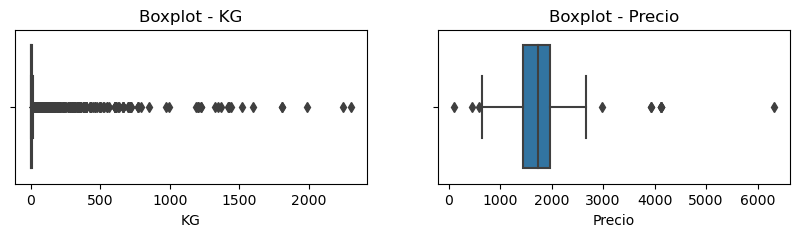

In [95]:
# Crear una figura y ejes compartidos
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 2))

# Boxplot para Campo1
sns.boxplot(x=df5['KG'], ax=axs[0])
axs[0].set_title('Boxplot - KG')

# Boxplot para Campo2
sns.boxplot(x=df5['Precio'], ax=axs[1])
axs[1].set_title('Boxplot - Precio')

    El dataset nos adelantaron que es inflacionario, lo cual por definición nos quitaría poder explicativo del volumen explicado por precios, como únicas variables. En qué marco temporal se ubican las ventas del dataset?

In [97]:
df5.groupby(['Semana', 'Semana (Lunes)'])[['Semana','Semana (Lunes)']].count()

,,Semana,Semana (Lunes)
Semana,Semana (Lunes),,
14,27/3/2023,11117,11117
15,3/4/2023,8674,8674
17,17/4/2023,9363,9363
18,24/4/2023,9568,9568
19,1/5/2023,10000,10000
20,8/5/2023,11122,11122


    El dataset se conforma por ventas en las semanas entre fin de Marzo y primera quincena de Abril, con un faltante de datos en la semana 16 (10/04/2023).
    Como sabemos, el dataset se conforma de datos de AMBA. La inflación en la región AMBA en abril 2023 de Alimentos y Bebidas No Alcohólicas [INDEC] fue de 8,4%.

### El resto del análisis se encontraba en modo exploratorio y no debería ser considerado como el definitivo.
### Como planificado para el EDA, falta:
#####         Eliminación de outliers mediante método intercuartil,
#####         Histograma de precio / KG por tipo de producto, o por U / Pack,
#####         Análisis de precio por Canal y por Zona
#####         Scatterplot de precio/demanda por Canal, Producto, Zona, u otros

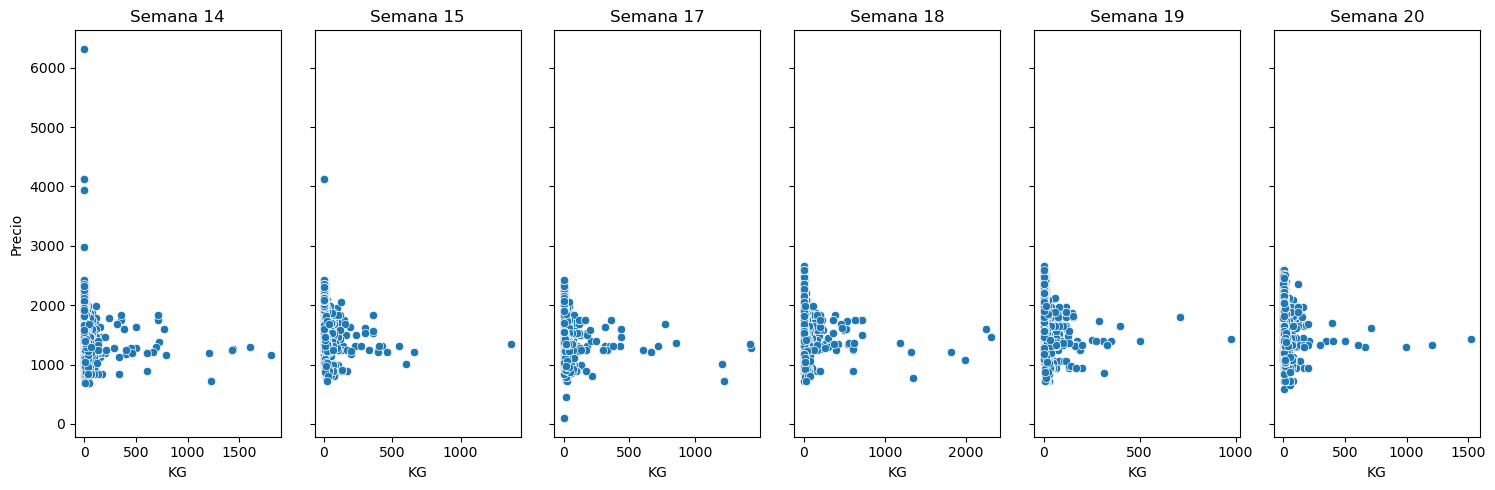

In [93]:
# Crear una figura y ejes compartidos
fig, axs = plt.subplots(1, 6, sharey=True, figsize=(15, 5))  # 1 fila, 3 columnas

# Scatter plot 1
sns.scatterplot(x='KG', y='Precio', data=df5[df5['Semana']==14], ax=axs[0])
axs[0].set_title('Semana 14')

# Scatter plot 2
sns.scatterplot(x='KG', y='Precio', data=df5[df5['Semana']==15], ax=axs[1])
axs[1].set_title('Semana 15')

# Scatter plot 3
sns.scatterplot(x='KG', y='Precio', data=df5[df5['Semana']==17], ax=axs[2])
axs[2].set_title('Semana 17')

# Scatter plot 4
sns.scatterplot(x='KG', y='Precio', data=df5[df5['Semana']==18], ax=axs[3])
axs[3].set_title('Semana 18')

# Scatter plot 5
sns.scatterplot(x='KG', y='Precio', data=df5[df5['Semana']==19], ax=axs[4])
axs[4].set_title('Semana 19')

# Scatter plot 6
sns.scatterplot(x='KG', y='Precio', data=df5[df5['Semana']==20], ax=axs[5])
axs[5].set_title('Semana 20')

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

    Por otro lado, el dataset incluye datos de varios canales de venta.

In [42]:
df5.Canal.value_counts()

Canal
Autoservicios + Petit    35837
Almacenes                 9788
Kioscos                   5286
Otros                     3618
Fiambrerias               2203
Mayoristas                1862
Gastronómicos             1104
Pollerias                   62
Distribuidores              58
Industria                   26
Name: count, dtype: int64

Los canales podría ocurrir que tengan distintos precios si algunos canales (los clientes de los distribuidores) fueron ellos mismos modalidad B2B o B2C. Esto lo podríamos observar comparando el precio al que se le vendió a cada canal.}

[Text(0, 0, 'Autoservicios + Petit'),
 Text(1, 0, 'Almacenes'),
 Text(2, 0, 'Kioscos'),
 Text(3, 0, 'Fiambrerias'),
 Text(4, 0, 'Gastronómicos'),
 Text(5, 0, 'Mayoristas'),
 Text(6, 0, 'Distribuidores'),
 Text(7, 0, 'Industria'),
 Text(8, 0, 'Otros'),
 Text(9, 0, 'Pollerias')]

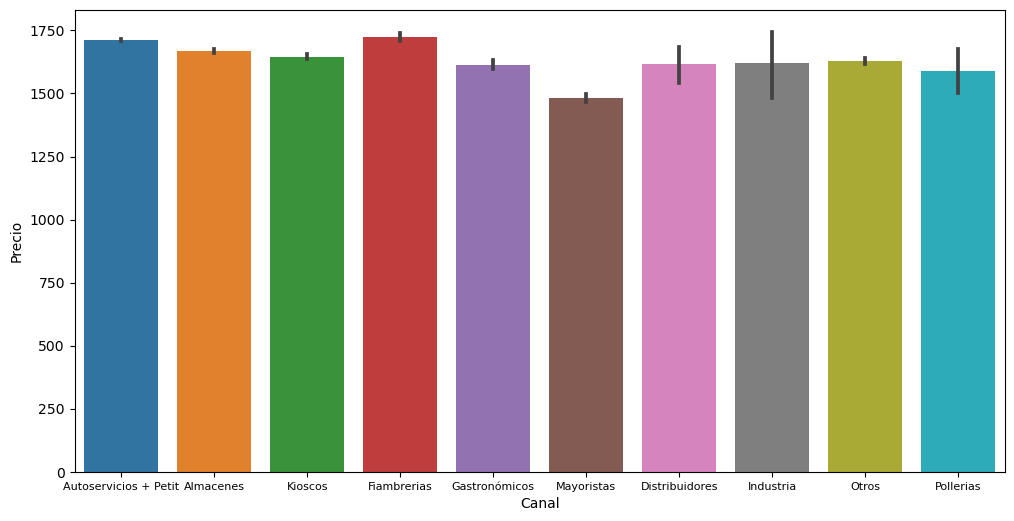

In [69]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df5, x='Canal', y='Precio')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)